In [1]:
import torch
import torchvision.transforms as transforms 
import torch.nn.init
from torchsummary import summary as summary_
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets

In [2]:
#Train data 받아오기


path_dir = 'LJH/data/product_data/train/Item-Parse_f' #Parse 폴더에서 파일명 불러오기
file_list_train = os.listdir(path_dir)
file_list_train

['1029391_B.json',
 '1112498_B.json',
 '1028177_B.json',
 '1020155_F.json',
 '1211013_F.json',
 '1202318_B.json',
 '1106198_B.json',
 '1013308_F.json',
 '1203208_B.json',
 '1117018_B.json',
 '1102028_F.json',
 '1126265_F.json',
 '1116527_B.json',
 '1015504_F.json',
 '1210536_B.json',
 '1106310_B.json',
 '1110001_F.json',
 '1112457_F.json',
 '1113098_B.json',
 '1117398_F.json',
 '1118168_B.json',
 '1207459_B.json',
 '1202394_B.json',
 '1207226_B.json',
 '1210501_B.json',
 '1110257_F.json',
 '1105665_F.json',
 '1111228_B.json',
 '1201441_F.json',
 '1016098_B.json',
 '1209278_F.json',
 '1126164_B.json',
 '1021215_F.json',
 '1124325_B.json',
 '1127276_B.json',
 '1023287_F.json',
 '1111019_B.json',
 '1201414_F.json',
 '1109545_B.json',
 '1022058_B.json',
 '1027403_B.json',
 '1211241_B.json',
 '1030308_B.json',
 '1028308_F.json',
 '1120072_B.json',
 '1210797_F.json',
 '1013179_B.json',
 '1015155_B.json',
 '1027136_B.json',
 '1029395_B.json',
 '1117139_F.json',
 '1126300_B.json',
 '1118078_F.

In [3]:
# 경로 생성

#TRAIN_SIZE = 33170
TRAIN_SIZE = 10000

#label = [0 for i in range(len(file_list_train))] #list형
label = [0 for i in range(10000)]
path_dir_img = 'LJH/data/product_data/train/Item-Image'

def make_file_list():
    #train_img_list = [0 for i in range(len(file_list_train))]
    train_img_list = [0 for i in range(10000)]
    cnt = 0
    for i in range(10000):
    
        with open(path_dir +'/'+ file_list_train[cnt], "r") as st_json:
            load_data = json.load(st_json)

        category = load_data.get('category_id') #class 찾아오기
        #print(category)
        str = file_list_train[cnt].split('.')[0]
        train_img_list[cnt] = path_dir_img +'/'+ str+".jpg" #이미지파일 파일명 생성
        label[cnt] = category

        cnt+=1

    return train_img_list

In [4]:
"""train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])



print(train_meanR, train_meanG, train_meanB)"""

'train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]\ntrain_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]\n\ntrain_meanR = np.mean([m[0] for m in train_meanRGB])\ntrain_meanG = np.mean([m[1] for m in train_meanRGB])\ntrain_meanB = np.mean([m[2] for m in train_meanRGB])\ntrain_stdR = np.mean([s[0] for s in train_stdRGB])\ntrain_stdG = np.mean([s[1] for s in train_stdRGB])\ntrain_stdB = np.mean([s[2] for s in train_stdRGB])\n\n\n\nprint(train_meanR, train_meanG, train_meanB)'

In [5]:
class ImageTransform():

    def __init__(self):
        
        self.data_transform = transforms.Compose([
            transforms.CenterCrop(720),
            transforms.Resize(256),
            #transforms.Normalize([train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB]),
            transforms.ToTensor(),
        ])
        

    def __call__(self, img):
        return self.data_transform(img)

In [6]:
class Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        img_label = label[index]

        return img_transformed,img_label

In [7]:
train_img_list=make_file_list()

In [8]:
train_dataset = Img_Dataset(file_list=train_img_list,
                            transform=ImageTransform())

In [9]:
train_dataloader = data.DataLoader(train_dataset,
                                   batch_size=128,
                                   shuffle=True)
print('Dataloader created')

Dataloader created


In [10]:
print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [11]:
batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

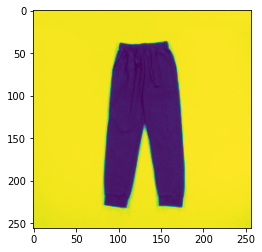

In [12]:
plt.imshow(images[0][3][0])
plt.show() 

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
class VGG11(nn.Module):
    def __init__(self,init_weights: bool = True):
        super(VGG11, self).__init__()
        self.convnet = nn.Sequential(
            # Input Channel (RGB: 3)
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        self.avgpool = nn.AdaptiveAvgPool2d((8, 8))
        self.fclayer = nn.Sequential(
            nn.Linear(512 * 8 * 8, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 5),
        )
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.convnet(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fclayer(x)
        return x

In [15]:
from torchsummary import summary as summary_
model = VGG11().to(device)
summary_(model,(3,256,256),batch_size = 128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 256, 256]           1,792
              ReLU-2        [128, 64, 256, 256]               0
         MaxPool2d-3        [128, 64, 128, 128]               0
            Conv2d-4       [128, 128, 128, 128]          73,856
              ReLU-5       [128, 128, 128, 128]               0
         MaxPool2d-6         [128, 128, 64, 64]               0
            Conv2d-7         [128, 256, 64, 64]         295,168
              ReLU-8         [128, 256, 64, 64]               0
            Conv2d-9         [128, 256, 64, 64]         590,080
             ReLU-10         [128, 256, 64, 64]               0
        MaxPool2d-11         [128, 256, 32, 32]               0
           Conv2d-12         [128, 512, 32, 32]       1,180,160
             ReLU-13         [128, 512, 32, 32]               0
           Conv2d-14         [128, 512,

/home/rpc/venv_envs/junha/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [16]:
criterion = torch.nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
total_batch = len(train_dataloader)
for epoch in range(10): 
    avg_cost = 0 
    cnt = 0
    
    for X, Y in train_dataloader: 
        X = X.to(device) 
        Y = Y.to(device) 
        
        optimizer.zero_grad() 
        hypothesis = model(X) 
        cost = criterion(hypothesis, Y) 
        cost.backward() 
        optimizer.step() 
       
        avg_cost += cost / total_batch
        if cnt% 100 == 0:
            print(cnt)
        cnt+=1
           
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

0
[Epoch:    1] cost = 1.25352621
0
[Epoch:    2] cost = 1.02630699
0
[Epoch:    3] cost = 0.94029665
0
[Epoch:    4] cost = 0.703510106
0
[Epoch:    5] cost = 0.525069892
0
[Epoch:    6] cost = 0.439898014
0
[Epoch:    7] cost = 0.37635085
0
[Epoch:    8] cost = 0.344398081
0
[Epoch:    9] cost = 0.311745137
0
[Epoch:   10] cost = 0.295718223


In [18]:
# test set 경로 생성


path_dir = 'LJH/data/product_data/test/Item-Parse_f'
path_dir_img = 'LJH/data/product_data/test/Item-Image'
file_list_test = os.listdir(path_dir)
#label_test = [0 for i in range(len(file_list_test))] #list형
label_test = [0 for i in range(500)] 
def make_file_list_test():
    #test_img_list = [0 for i in range(len(file_list_test))]
    test_img_list = [0 for i in range(500)]
    cnt = 0
    #for i in file_list_test:
    for i in range(500):
    
        with open(path_dir +'/'+ file_list_test[cnt], "r") as st_json:
            load_data = json.load(st_json)

        category = load_data.get('category_id') #class 찾아오기
        #print(category)
        str = file_list_test[cnt].split('.')[0]
        test_img_list[cnt] = path_dir_img +'/'+ str+".jpg" #이미지파일 파일명 생성
        label_test[cnt] = category

        cnt+=1

    return test_img_list

In [19]:
test_img_list=make_file_list_test()

In [20]:
# test set 전처리

from torchvision.transforms import ToTensor
X_test = torch.empty(0,3,256,256)


image_w = 256 
image_h = 256
cnt_img = 0
for j in test_img_list:
    image = Image.open(test_img_list[cnt_img])
    image = image.crop((0,280,720,1000))
    image = image.resize((256, 256))
    data = ToTensor()(image).unsqueeze(0)
    X_test =torch.cat([X_test,data],dim=0)
    cnt_img += 1
    if cnt_img % 1000 == 0:
        print(cnt_img)

In [21]:
print(X_test.shape)

torch.Size([500, 3, 256, 256])


In [22]:
Y_test = torch.tensor(label_test)

In [23]:
with torch.no_grad(): 
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    prediction = model(X_test) 
    print(prediction.size()) 
    correct_prediction = torch.argmax(prediction, 1) == Y_test 
    accuracy = correct_prediction.float().mean() 
    print('Accuracy: ', accuracy.item())

torch.Size([500, 5])
Accuracy:  0.9020000696182251
